# Reminder to startup the Unity render binary if it is not already running!












Current pos: [  0. -15.  -2.]
Current attitude: [ 0.          0.         -1.57079633]
Target pose: [  9. -15.  -2.   0.]
Final pose [  7.43 -15.01  -2.01   0.  ]


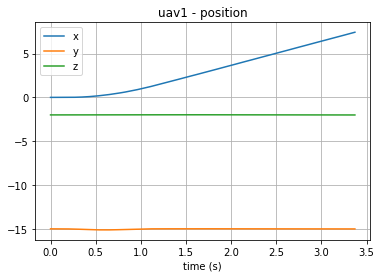

In [6]:
#!/usr/bin/env python
# coding: utf-8
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import sys
import numpy as np
from IPython.display import HTML, display

sys.path.insert(0, '../')
from flightgoggles.env import *

if __name__ == "__main__":
    env = flightgoggles_env(
        cfg_dir="../config",
        cfg_fgclient="FlightGogglesClient_testing.yaml",
        cfg_uav="multicopterDynamicsSim.yaml")
    
    # no collision start pos position=np.array([-15, -15., -2.])
    env.set_state_vehicle(vehicle_id="uav1",
                          position=np.array([0, -15., -2.]),
                          attitude_euler_angle=np.array([0.,0.,-np.pi/2]))
    
    current_pos = env.get_state("uav1")["position"]
    current_att = env.get_state("uav1")["attitude_euler_angle"]
    target_pose = np.zeros(4)
    # position and attitude -> pose
    target_pose[:3] = current_pos + np.array([9.0,0.0,0.0])
    target_pose[3] = current_att[2] + np.pi/2
    print("Current pos: {}".format(current_pos))
    print("Current attitude: {}".format(current_att))
    print("Target pose: {}".format(target_pose))
        
    # proceed_waypoint -> fix a location to go toward; duration is the  delta time in PID loop
    for j in range(600):
        collided = env.proceed_waypoint(vehicle_id="uav1", waypoint_command=target_pose, duration=0.01)
        if collided:
            break
    
    env.plot_state(vehicle_id="uav1", attribute="position")
    env.save_logs(vehicle_id="uav1", save_dir="data/")
    img = env.get_camera_image(camera_id="cam1")
   # print(img[-1]["timestamp"])
    
    final_pos = env.get_state("uav1")["position"]
    final_att = env.get_state("uav1")["attitude_euler_angle"]
#     print("Final pos: {}".format(final_pos))
#     print("Final attitude: {}".format(final_att))
    with np.printoptions(precision=2, suppress=True):
        print("Final pose", np.append(final_pos, final_att[2]))
    
    # env.plot_state_camera(camera_id=None) last cmaera img. only 1 camera on uav1

    ani_set = env.plot_state_video(flag_save=False, filename="uav", dpi=400)
    if "cam1" in ani_set.keys():
        display(HTML(ani_set["cam1"].to_html5_video()))
    env.close()